In [2]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf

from sklearn.preprocessing import MultiLabelBinarizer
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras.layers import Activation, Flatten, Dropout, Dense

In [36]:
batch_size = 32
img_height = 180
img_width = 180

In [37]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  './images/train',
  validation_split=0.2,
  subset="training",
  seed=32,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3895 files belonging to 36 classes.
Using 3116 files for training.


In [38]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
   './images/train',
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3895 files belonging to 36 classes.
Using 779 files for validation.


In [39]:
class_names = train_ds.class_names
print(class_names)

['bandad-i1', 'bandad-i2', 'beodeunamu', 'beodeunamu2', 'bulg-eunmaehwa', 'bulg-eunmaehwa2', 'chas-sabal', 'chas-sabal2', 'cheongdong tugu', 'geuleus badchim', 'geuleus-ina eumsig-eul bogwanhaneun ta', 'geuleus-ina eumsig-eul bogwanhaneun tagja', 'geuleus-ina eumsig-eul bogwanhaneun tagja2', 'geumdong-', 'geumdong-gwan', 'hang-ali', 'icheungchang (2)', 'icheungchang2 (2)', 'maehwa', 'maehwa2', 'mangcheongjang2', 'mangcheongjang3', 'moglyeon', 'moglyeon2', 'myeong-gyeongdae1', 'myeong-gyeongdae2', 'nahan', 'nancho,daenamu,bawi', 'nancho,daenamu,bawi2', 'nancho1', 'nancho2', 'sajasang2', 'sajasang3', 'sajasang4', 'uibog', 'uibog2']


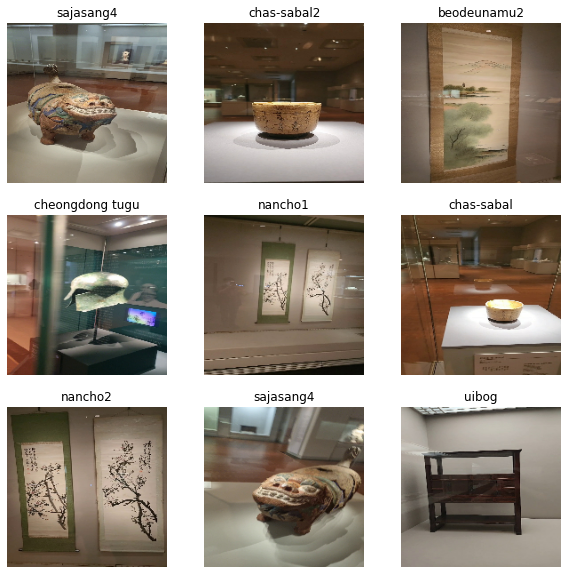

In [40]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [42]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 180, 180, 3)
(32,)


In [43]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [44]:
normalization_layer = layers.experimental.preprocessing.Rescaling(1./255)

In [45]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixels values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0 1.0


In [48]:
num_classes = 36

model = Sequential([
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, (3,3), padding='same', activation='relu'),
  layers.BatchNormalization(axis=-1),
  layers.MaxPooling2D(pool_size=(3,3)),
  layers.Dropout(0.25),

  layers.Conv2D(64,(3,3), padding='same', activation='relu'),
  layers.BatchNormalization(axis=-1),
  layers.Conv2D(64,(3,3), padding='same', activation='relu'),
  layers.BatchNormalization(axis=-1),
  layers.MaxPooling2D(pool_size=(2,2)),
  layers.Dropout(0.25),

  layers.Conv2D(128,(3,3), padding='same', activation='relu'),
  layers.BatchNormalization(axis=-1),
  layers.Conv2D(128,(3,3), padding='same', activation='relu'),
  layers.BatchNormalization(axis=-1),
  layers.MaxPooling2D(pool_size=(2,2)),
  layers.Dropout(0.25),

  layers.Conv2D(256,(3,3), padding='same', activation='relu'),
  layers.BatchNormalization(axis=-1),
  layers.Conv2D(256,(3,3), padding='same', activation='relu'),
  layers.BatchNormalization(axis=-1),
  layers.MaxPooling2D(pool_size=(2,2)),
  layers.Dropout(0.25),

  layers.Flatten(),
  layers.Dense(2048, activation='relu'),
  layers.BatchNormalization(),
  layers.Dropout(0.5),

  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes,activation='softmax'),
])

In [49]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [50]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_8 (Rescaling)      (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d_35 (Conv2D)           (None, 180, 180, 16)      448       
_________________________________________________________________
batch_normalization_40 (Batc (None, 180, 180, 16)      64        
_________________________________________________________________
max_pooling2d_20 (MaxPooling (None, 60, 60, 16)        0         
_________________________________________________________________
dropout_25 (Dropout)         (None, 60, 60, 16)        0         
_________________________________________________________________
conv2d_36 (Conv2D)           (None, 60, 60, 64)        9280      
_________________________________________________________________
batch_normalization_41 (Batc (None, 60, 60, 64)        2

In [ ]:
epochs=10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10
58/98 [================>.............] - ETA: 39s - loss: 3.1576 - accuracy: 0.4831

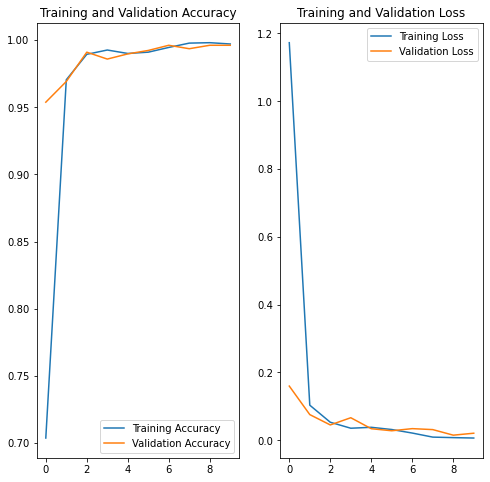

In [59]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss=history.history['loss']
val_loss=history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [60]:
data_augmentation = keras.Sequential(
  [
    layers.experimental.preprocessing.RandomFlip("horizontal",
                                                 input_shape=(img_height,
                                                              img_width,
                                                              3)),
    layers.experimental.preprocessing.RandomRotation(0.1),
    layers.experimental.preprocessing.RandomZoom(0.1),
  ]
)

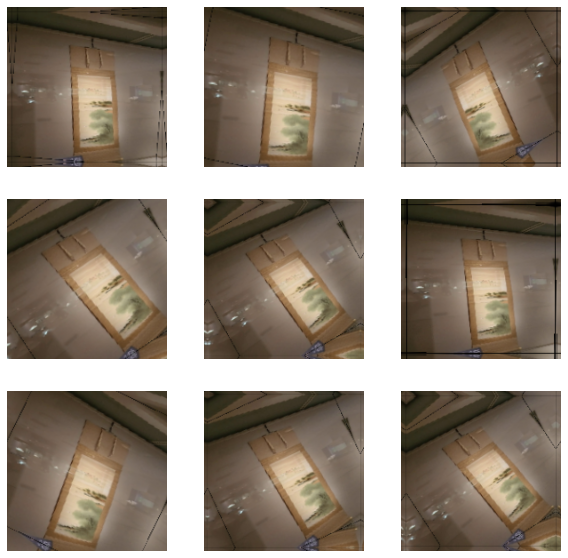

In [61]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

In [62]:
model = Sequential([
  data_augmentation,
  layers.experimental.preprocessing.Rescaling(1./255),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(128, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(256, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(512, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(256, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(128, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [63]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [64]:
model.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_7 (Sequential)    (None, 180, 180, 3)       0         
_________________________________________________________________
rescaling_8 (Rescaling)      (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d_26 (Conv2D)           (None, 180, 180, 64)      1792      
_________________________________________________________________
max_pooling2d_26 (MaxPooling (None, 90, 90, 64)        0         
_________________________________________________________________
conv2d_27 (Conv2D)           (None, 90, 90, 128)       73856     
_________________________________________________________________
max_pooling2d_27 (MaxPooling (None, 45, 45, 128)       0         
_________________________________________________________________
conv2d_28 (Conv2D)           (None, 45, 45, 256)      

In [ ]:
epochs = 15
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)
model.save('./pj.h5')

Epoch 1/15
98/98 [==============================] - 197s 2s/step - loss: 3.0989 - accuracy: 0.1428 - val_loss: 2.5340 - val_accuracy: 0.2567
Epoch 2/15
98/98 [==============================] - 191s 2s/step - loss: 2.1233 - accuracy: 0.3511 - val_loss: 1.5152 - val_accuracy: 0.4852
Epoch 3/15
98/98 [==============================] - 188s 2s/step - loss: 1.4534 - accuracy: 0.5295 - val_loss: 1.0349 - val_accuracy: 0.6457
Epoch 4/15
98/98 [==============================] - 185s 2s/step - loss: 1.1073 - accuracy: 0.6245 - val_loss: 0.9978 - val_accuracy: 0.6906
Epoch 5/15
98/98 [==============================] - 192s 2s/step - loss: 0.8508 - accuracy: 0.7009 - val_loss: 0.6038 - val_accuracy: 0.7908
Epoch 6/15
98/98 [==============================] - 188s 2s/step - loss: 0.7421 - accuracy: 0.7474 - val_loss: 0.5084 - val_accuracy: 0.8190
Epoch 7/15
98/98 [==============================] - 192s 2s/step - loss: 0.5322 - accuracy: 0.8119 - val_loss: 0.4370 - val_accuracy: 0.8472
Epoch 8/15
98

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
sunflower_path = "./test/중간내용-003.jpg"
img = keras.preprocessing.image.load_img(
    sunflower_path, target_size=(img_height, img_width)
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])
# for i in score:
#   print(i)
# print(
#     "This image most likely belongs to {} with a {:.2f} percent confidence."
#     .format(class_names[np.argmax(score)], 100 * np.max(score))
# )
a = class_names[np.argmax(score)]
b = np.max(score)

if b > 0.90 :
  print(
       "이 작품의 이름은" +" "+ "{} ".format(a)
  )
  print(
       "확률은" + "{} ".format(b)
  )
else:
  print("다시 촬영해주세요")


print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)